In [7]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os
import numpy as np
import torch.nn as nn
import pandas as pd
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import cv2
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchaudio.__version__)

1.11.0
0.11.0


In [8]:
dirpath='../../dataset/AEC-Challenge/datasets/synthetic/'
desired,sr= librosa.load(dirpath+'nearend_mic_signal/nearend_mic_fileid_0.wav')
input,sr=librosa.load(dirpath+'/farend_speech/farend_speech_fileid_0.wav')
echo,sr=librosa.load(dirpath+'/echo_signal/echo_fileid_0.wav')
near_end,sr= librosa.load(dirpath+'/nearend_speech/nearend_speech_fileid_0.wav')

Feature extraction class and APIs

In [281]:
class FeatureExtractor():
    def __init__(self,fft_len,hop_size,sr):
        self.fft_len=fft_len*sr//1000
        self.hop_size=hop_size*sr//1000
        self.sr= sr
        self.spec_dims=(160,32)
        self.fft_buff=np.zeros((self.fft_len,1))
        self.ifft_buff=np.zeros((self.fft_len,1))
        self.wnd=np.hanning(self.fft_len)
        self.zbuf=np.zeros((self.hop_size,1))
        self.specgram=np.zeros((self.spec_dims[0],self.spec_dims[1]))

    def stft(self,x):
        R=self.hop_size
        M= self.fft_len
        x=x.reshape((x.shape[0],-1))
        self.fft_buff[M-R:,:]=x
        xw=np.multiply(self.fft_buff.T,self.wnd)
        fft_xw=np.fft.fft(xw,n=M).T
        self.fft_buff[:M-R,:]=self.fft_buff[R:,:]
        return fft_xw

    def istft(self,x):
        R=self.hop_size
        M= self.fft_len
        iift_xw= np.fft.ifft(x.T,self.fft_len)
        y=self.ifft_buff[:R]
        self.ifft_buff[:M-R]=self.ifft_buff[R:]
        self.ifft_buff[M-R:]=self.zbuf
        self.ifft_buff=self.ifft_buff+iift_xw.T
        return y.real
    
    def spectrogram(self,fft_x):
        y=cv2.normalize(self.specgram, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        self.specgram[:,:-1]=self.specgram[:,1:]
        self.specgram[:,-1]=np.abs(fft_x)[:160,0]
        y=np.flip(y,0)
        return y
    

Test wrapper to verify stft operation

In [282]:
# in ms
fft_len=40
hop_size=10
duration=32*fft_len*sr//1000
sr=8000
input,sr=librosa.load(dirpath+'/farend_speech/farend_speech_fileid_0.wav',sr=8000,duration=32*fft_len/1000)
print(len(input))
incr=hop_size*sr//1000
spects=[]
ft= FeatureExtractor(fft_len,hop_size,sr)
cnt=0
ff=[]
ifft=[]
for i in range(0,len(input),incr):
    fft_ip=ft.stft(input[i:i+incr])
    ff.append(fft_ip)
    ifft_ip=ft.istft(fft_ip)
    #print(ifft_ip.dtype)
    ifft.append(ifft_ip)
    spec=ft.spectrogram(fft_ip)
    spects.append(spec)
    cnt+=1

10240


In [283]:
tff=np.array(np.abs(ff))
fft1=np.flip(tff.T.squeeze(0)[:160,:],0)
fft1=cv2.normalize(fft1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [284]:
ifft2=np.array(ifft)
ifft2=ifft2.squeeze(-1)
ifft2=ifft2.reshape(ifft2.shape[0]*ifft2.shape[1],1)

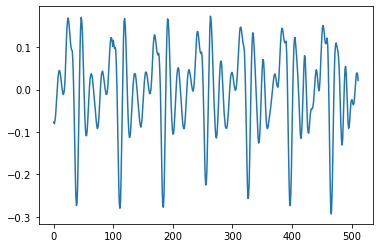

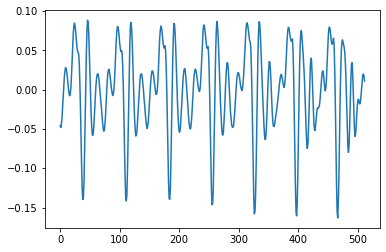

In [285]:
plt.figure()
offset=300
plt.plot(ifft2[offset+240:offset+512+240])
plt.figure()
plt.plot(input[offset:offset+512])

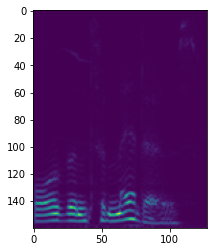

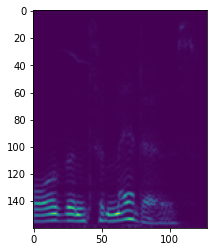

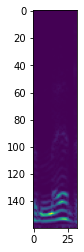

In [286]:
plt.figure()
plt.imshow(fft1)
fft2=np.flip(np.abs(librosa.stft(input,n_fft=318,hop_length=80)),0)[:,:-1]
plt.figure()
plt.imshow(fft2)
plt.figure()
plt.imshow(spects[82])

In [287]:
# in ms
fft_len=40
hop_size=10
duration=32*fft_len*sr//1000
sr=8000

In [288]:
incr=hop_size*sr//1000
spects=[]
ft= FeatureExtractor(fft_len,hop_size,sr)
ff=[]
for i in range(0,100):
    input,sr=librosa.load(dirpath+'/farend_speech/farend_speech_fileid_0.wav',sr=8000,duration=hop_size/1000, offset=i*hop_size/1000)
    fft_ip=ft.stft(input)
    ff.append(fft_ip)
    ifft_ip=ft.istft(fft_ip)
    spec=ft.spectrogram(fft_ip)
    spects.append(spec)

In [289]:
tff=np.array(np.abs(ff))
fft1=np.flip(tff.T.squeeze(0)[:160,:],0)
fft1=cv2.normalize(fft1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

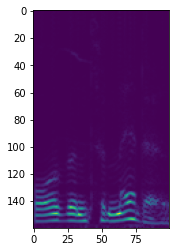

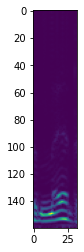

In [290]:
plt.figure()
plt.imshow(fft1)
plt.figure()
plt.imshow(spects[82])